# Homework I

### Due Date: 11:55 PM Wednesday, Feb 14, 2018

You should turn in the notebook at Columbia CourseWorks website.</li>

Before you turn in the notebook, press the "Run all cells" button in the toolbar, and make sure all the calculation results and graphs are produced correctly, and then save the notebook.

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import laguerre
from scipy.interpolate import interp1d
plt.rc('figure', figsize=(6, 5))
plt.rc('axes', grid=True, xmargin=0, ymargin=0, autolimit_mode='round_numbers')

# 1. Conditional Expection and Least Square Regression

Let $X$ and $Y$ be two random variables. The conditional expectation $E[Y|X]$ is a function $f^{\ast}$ of $X$ that best approximates $Y$ in the least square sense, i.e.,

$$E[Y|X]=f^{\ast}(X)\quad\text{and}\quad E[|Y-f^{\ast}(X)|^2] \leq E[|Y-f(X)|^2]\text{ for any function }f\text{ of }X$$

Let us define the random variables $X$ and $Y$ by
$$
g(x) = x \frac{1 + x}{1 + x^2}, \qquad X \sim \mathcal{N}(0, 1), \quad Y = g(X) + \varepsilon
$$
where $\varepsilon \sim \mathcal{N}(0, 1/16)$ is independent of $X$.

Note that $E[Y|X] = E[g(X)+\varepsilon|X] = g(X)+E[\varepsilon|X] = g(X)$.

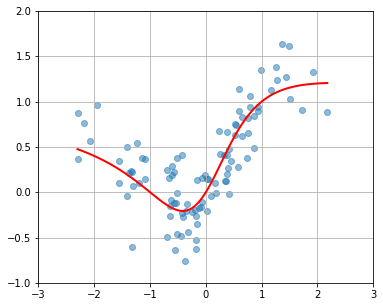

In [20]:
# Plot a random sample of the joint distribution and the 
# theoretical conditional expectation of Y wrt X.

def f(x):
    return x*(1+x)/(1+x**2)

n = 100
sigma = 0.25
X = np.random.randn(n)
Y = f(X) + sigma * np.random.randn(n)

fig, ax = plt.subplots()
ax.scatter(X, Y, alpha=0.5)
x = np.linspace(X.min(), X.max(), 101)
ax.plot(x, f(x), 'r', linewidth=2)

## Parametric regression

The conditional expection $E\left[Y|X\right]$ is approximated by a linear combination of a set of given <em>basis</em> functions $\{f_i(X)\}_{0\leq i\leq n}$, i.e.,

$$E\left[Y|X\right]\approx \beta_0^*f_0(X)+\cdots+\beta_n^*f_n(X)$$

where 

$$E[(Y-\beta_0^*f_0(X)-\cdots-\beta_n^*f_n(X))^2] = \min_{\beta_1,\ldots,\beta_n} E[(Y-\beta_0f_0(X)-\cdots-\beta_nf_n(X))^2]$$

Given $N$ observations $\left((x_1,y_1),\ldots,(x_N, y_N)\right)$ of $X$ and $Y$, one finds the optimal parameters $\beta_i$ by solving the least square problem $\min_\alpha\|A\beta-y\|_2$, where
$$A=\begin{bmatrix}f_0(x_1) & \cdots & f_n(x_1)\\ \vdots & \ddots & \vdots \\ f_0(x_N) & \cdots & f_n(x_N)\end{bmatrix}\quad
\text{and}\quad y=\begin{bmatrix}y_1\\ \vdots \\ y_N\end{bmatrix}$$

The numpy routine <strong>numpy.linalg.lstsq</strong> can be used to solve such linear least square problems.

### Polynomials

The basis functions are taken to be power functions $f_i(X)=X^{i}$, that is $\mathbb{E}\left[Y|X\right]$ is a polynomial of $X$. The numpy routine <strong>numpy.polyfit</strong> is a convenient way to obtain the least square polynomial fit.

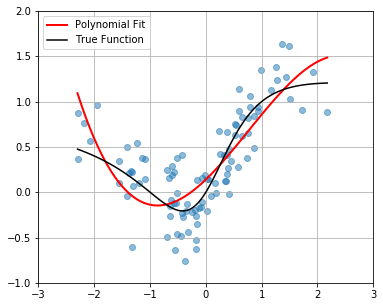

In [21]:
# Fit a polynomial of degree 3 to the sample points (X, Y)
p = np.polyfit(X, Y, deg=3)
fig, ax = plt.subplots()
ax.scatter(X, Y, alpha=0.5)
ax.plot(x, np.polyval(p, x), 'r', lw=2, label='Polynomial Fit')
ax.plot(x, f(x), 'k', label='True Function')
ax.legend(loc=0)

### Laguerre Polynomials

The <em>Laguerre</em> polynomials are defined by

$$L_n(x)=\frac{1}{n!}\left(\frac{d}{dx}-1\right)^nx^n.$$

In particular, we have

$$L_0(x)=1,\quad L_1(x)=-x+1,\quad L_2(x)=\frac{1}{2}\left(x^2-4x+2\right),\quad\cdots$$

They are orthogonal polynomials with respect to the inner product $\langle f, g\rangle=\int_0^{\infty}f(x)g(x)e^{-x}dx$. Therefore we will be actually using the weighted version 

$$\tilde{L}_n(x)=e^{-x/2}L_n(x)$$

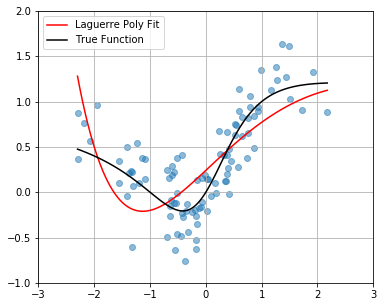

In [22]:
L = lambda x, i: laguerre(i)(x)*np.exp(-x/2)
A = np.vstack((L(X, 0), L(X, 1), L(X, 2))).T
p = np.linalg.lstsq(A, Y)[0]
fig, ax = plt.subplots()
ax.scatter(X, Y, alpha=0.5)
ax.plot(x, L(x,0)*p[0]+L(x,1)*p[1]+L(x,2)*p[2], 'r', label='Laguerre Poly Fit')
ax.plot(x, f(x), 'k', label='True Function')
ax.legend(loc=0)

### Piecewise Linear Regression

In [13]:
def piecewiselinear_reg(xdata, ydata, xknots, extrapolate='linear'):
    """
    Parameters
    ----------
    xdata: array_like
        The x-coordinates of the data points.
    ydata: array_like
        The y-coordinates of the data points.
    xknots: array_like
        The x-coordinates of the knots of the piecewise linear function, must be increasing.
    extrapolate: str
        Must be either 'linear' (linear extrapolation) or 'const' (constant extrapolation)
    
    It returns a function which uses the best piecewise-linear fit to
    find the value of new points.
    """
    nknots = len(xknots)
    diag = np.identity(nknots)
    A = np.vstack([np.interp(xdata, xknots, diag[i]) for i in range(nknots)]).T
    yknots = np.linalg.lstsq(A, ydata)[0]
    extrapolate = extrapolate.lower()
    if extrapolate == 'linear':
        fi = interp1d(xknots, yknots, kind='linear', fill_value='extrapolate')
    elif extrapolate == 'const':
        fi = interp1d(xknots, yknots, kind='linear', bounds_error=False, fill_value=(yknots[0], yknots[-1]))
    else:
        raise ValueError("The value of 'extrapolate' must be 'linear' or 'const'.")
    return fi

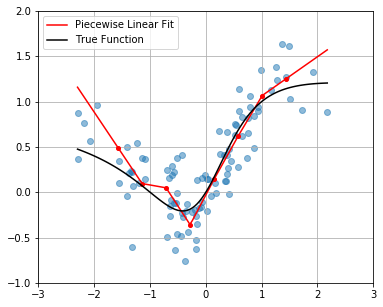

In [23]:
xknots = np.linspace(np.percentile(X, 5), np.percentile(X, 95), 8)
fpl = piecewiselinear_reg(X, Y, xknots, 'linear')
fig, ax = plt.subplots()
ax.scatter(X, Y, alpha=0.5)
ax.plot(xknots, fpl(xknots), 'o', markersize=4, color='r')
ax.plot(x, fpl(x), 'r', label='Piecewise Linear Fit')
ax.plot(x, f(x), 'k', label='True Function')
ax.legend(loc=0)

## Nonparametric regression

### Nadaraya-Watson Kernel regression (Local Weighted Average)

Here, no parametric form is assumed for $\mathbb{E}[Y|X]$. Instead, local averages of $Y$ values are computed, given the value of $X$:

$$\mathbb{E}\left[Y|X\right]\approx\frac{\sum_{i=1}^NK_h(x-x_i)y_i}{\sum_{i=1}^NK_h(x-x_i)}$$
where $K$ is a kernel function and $K_h(x)=K(x/h)$, $h$ is the <em>bandwidth</em>. $K_h$ approximates the Dirac mass at zero.

### Local Linear Regression

The locally weighted linear regression solves a separate weighted least squares problem at each target point $x$,

$$\hat{\alpha},\hat{\beta} = \text{argmin}_{\alpha,\beta}\sum_{i=1}^NK_h(x-x_i)\left[y_i-\alpha-\beta x_i\right]^2$$

which yields an estimate $\hat{\alpha}+\hat{\beta}x$. Note that $\hat{\alpha}$ and $\hat{\beta}$ depend on $x$. The locally-weighted averages can be badly biased on the boundaries. This bias
can be removed by local linear regression to the first order.

<b>Note.</b> To speed up, we often perform the local regression only at a selection of points and then use interpolation/extrapolation to evaluate at other target points.

In [24]:
# Non-parametric regression function

def gauss_kern(x):
    """Gaussian kernel function"""
    return np.exp(-x**2/2)

def kern_reg(x, xdata, ydata, bandwidth, kern=gauss_kern):
    """Nadaraya-Watson Kernel Regression (Locally weighted average)

    Parameters
    ----------
    x: array_like, one-dimensional
        The x-coordinates of the target points
    xdata: array_like
        The x-coordinates of the data points.
    ydata: array_like
        The y-coordinates of the data points. 
    bandwidth: positive scalar
        Bandwidth of the kernel
    kern: callable
        kernel function
    """
    weights = kern((xdata[:, np.newaxis] - x) / bandwidth)
    return np.sum(weights * ydata[:, np.newaxis], axis=0) / np.sum(weights, axis=0)


def ll_reg(x, xdata, ydata, bandwidth, kern=gauss_kern):
    """Local Linear Regression

    Parameters
    ----------
    x: array_like, one-dimensional
        The x-coordinates of the target points
    xdata: array_like
        The x-coordinates of the data points.
    ydata: array_like
        The y-coordinates of the data points. 
    bandwidth: positive scalar
        Bandwidth of the kernel
    kern: callable
        kernel function
    """
    
    def func(xx):
        weights = np.sqrt(kern((xdata-xx)/bandwidth))
        b = ydata*weights
        A = np.vstack((np.ones_like(xdata), xdata)).T*weights[:, np.newaxis]
        coefs = np.linalg.lstsq(A, b)[0]
        yy = coefs[0] + coefs[1]*xx
        return yy
    
    return np.vectorize(func)(x)

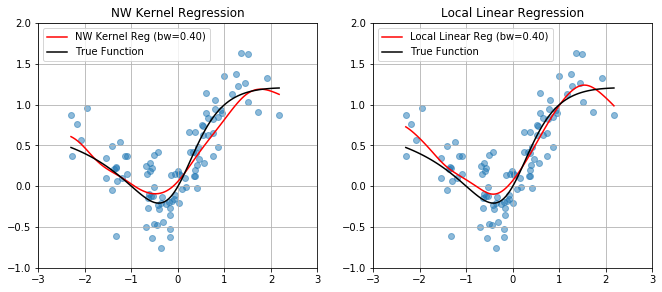

In [25]:
fig, axs = plt.subplots(1,2, figsize=(11, 4.5))
bw_silverman = (4/(3*len(X)))**0.2*np.std(X)
axs[0].plot(x, kern_reg(x, X, Y, bw_silverman, gauss_kern), color='r', label='NW Kernel Reg (bw={:.2f})'.format(bw_silverman))
axs[0].set_title('NW Kernel Regression')
axs[1].plot(x, ll_reg(x, X, Y, bw_silverman, gauss_kern), color='r', label='Local Linear Reg (bw={:.2f})'.format(bw_silverman))
axs[1].set_title('Local Linear Regression')
for ax in axs:
    ax.scatter(X, Y, alpha=0.5)
    ax.plot(x, f(x), 'k', label='True Function')
    ax.legend(loc=0)

## Questions

<b>Question 1.1</b>. (Parametric regression) In general, increasing the number of basis functions in the regression gives us more flexibility to better fit the data. However, having too many parameters in the model oftentimes leads to overfitting, which usually has poor predictive performance and is over-sensitive to small noise in the data. To observe the overftting phenomenon, in polynomial fit and Laguerre polynomial fit, try to use different degrees of the polynomials; in piecewise-linear regression, try to use difference number of knots. Then reproduce the scatter plot with fitted regression function. Compare and comment on the results.

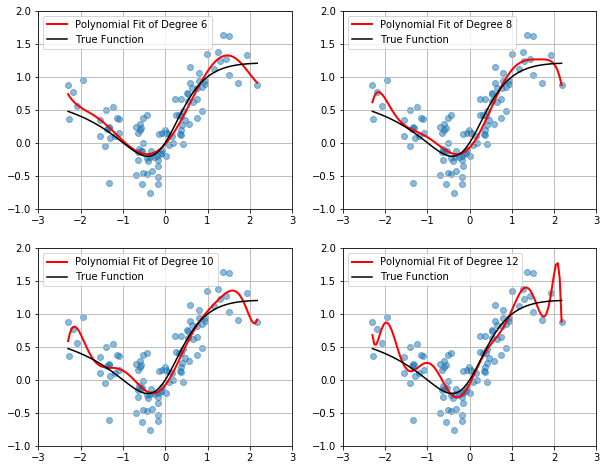

In [26]:
# Fit a polynomial with different degrees to the sample points (X, Y)
# Degree 6, 8, 10, 12 respectively
p1 = np.polyfit(X, Y, deg = 6)
p2 = np.polyfit(X, Y, deg = 8)
p3 = np.polyfit(X, Y, deg = 10)
p4 = np.polyfit(X, Y, deg = 12)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (10,8))
ax1.plot(x, np.polyval(p1, x), 'r', lw=2, label='Polynomial Fit of Degree 6')
ax1.scatter(X, Y, alpha=0.5)
ax1.plot(x, f(x), 'k', label='True Function')
ax1.legend(loc=0)
ax2.plot(x, np.polyval(p2, x), 'r', lw=2, label='Polynomial Fit of Degree 8')
ax2.scatter(X, Y, alpha=0.5)
ax2.plot(x, f(x), 'k', label='True Function')
ax2.legend(loc=0)
ax3.plot(x, np.polyval(p3, x), 'r', lw=2, label='Polynomial Fit of Degree 10')
ax3.scatter(X, Y, alpha=0.5)
ax3.plot(x, f(x), 'k', label='True Function')
ax3.legend(loc=0)
ax4.plot(x, np.polyval(p4, x), 'r', lw=2, label='Polynomial Fit of Degree 12')
ax4.scatter(X, Y, alpha=0.5)
ax4.plot(x, f(x), 'k', label='True Function')
ax4.legend(loc=0)

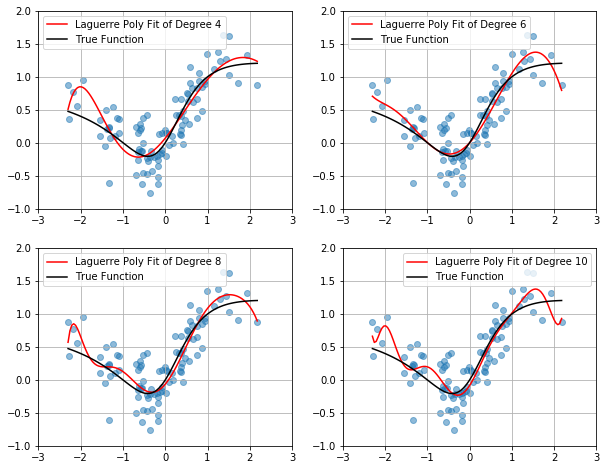

In [27]:
# Fit a Laguerre polynomial with different degrees to the sample points (X, Y)
# Degree 4, 5, 6, 7 respectively
L = lambda x, i: laguerre(i)(x)*np.exp(-x/2)
A1 = np.vstack((L(X, 0), L(X, 1), L(X, 2), L(X, 3), L(X, 4))).T
p1 = np.linalg.lstsq(A1, Y)[0]
A2 = np.vstack((L(X, 0), L(X, 1), L(X, 2), L(X, 3), L(X, 4), L(X, 5), L(X, 6))).T
p2 = np.linalg.lstsq(A2, Y)[0]
A3 = np.vstack((L(X, 0), L(X, 1), L(X, 2), L(X, 3), L(X, 4), L(X,5), L(X, 6), L(X, 7), L(X, 8))).T
p3 = np.linalg.lstsq(A3, Y)[0]
A4 = np.vstack((L(X, 0), L(X, 1), L(X, 2), L(X, 3), L(X, 4), L(X,5), L(X, 6), L(X, 7), L(X, 8), L(X, 9), L(X, 10))).T
p4 = np.linalg.lstsq(A4, Y)[0]
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize = (10,8))
ax1.scatter(X, Y, alpha=0.5)
ax1.plot(x, L(x,0)*p1[0]+L(x,1)*p1[1]+L(x,2)*p1[2]+L(x,3)*p1[3]+L(x,4)*p1[4], 'r', label='Laguerre Poly Fit of Degree 4')
ax1.plot(x, f(x), 'k', label='True Function')
ax1.legend(loc=0)
ax2.scatter(X, Y, alpha=0.5)
ax2.plot(x, L(x,0)*p2[0]+L(x,1)*p2[1]+L(x,2)*p2[2]+L(x,3)*p2[3]+L(x,4)*p2[4]+L(x,5)*p2[5]+L(x,6)*p2[6], 'r', label='Laguerre Poly Fit of Degree 6')
ax2.plot(x, f(x), 'k', label='True Function')
ax2.legend(loc=0)
ax3.scatter(X, Y, alpha=0.5)
ax3.plot(x, L(x,0)*p3[0]+L(x,1)*p3[1]+L(x,2)*p3[2]+L(x,3)*p3[3]+L(x,4)*p3[4]+L(x,5)*p3[5]+L(x,6)*p3[6]+L(x,7)*p3[7]+L(x,8)*p3[8], 'r', label='Laguerre Poly Fit of Degree 8')
ax3.plot(x, f(x), 'k', label='True Function')
ax3.legend(loc=0)
ax4.scatter(X, Y, alpha=0.5)
ax4.plot(x, L(x,0)*p4[0]+L(x,1)*p4[1]+L(x,2)*p4[2]+L(x,3)*p4[3]+L(x,4)*p4[4]+L(x,5)*p4[5]+L(x,6)*p4[6]+L(x,7)*p4[7]++L(x,8)*p4[8]++L(x,9)*p4[9]++L(x,10)*p4[10], 'r', label='Laguerre Poly Fit of Degree 10')
ax4.plot(x, f(x), 'k', label='True Function')
ax4.legend(loc=0)

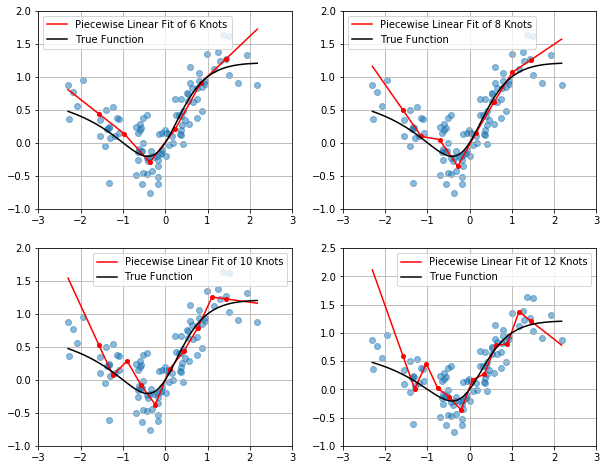

In [28]:
# Piece-wise regression with different number of knots
xknots1 = np.linspace(np.percentile(X, 5), np.percentile(X, 95), 6)
fpl1 = piecewiselinear_reg(X, Y, xknots1, 'linear')
xknots2 = np.linspace(np.percentile(X, 5), np.percentile(X, 95), 8)
fpl2 = piecewiselinear_reg(X, Y, xknots2, 'linear')
xknots3 = np.linspace(np.percentile(X, 5), np.percentile(X, 95), 10)
fpl3 = piecewiselinear_reg(X, Y, xknots3, 'linear')
xknots4 = np.linspace(np.percentile(X, 5), np.percentile(X, 95), 12)
fpl4 = piecewiselinear_reg(X, Y, xknots4, 'linear')
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,8))
ax1.scatter(X, Y, alpha=0.5)
ax1.plot(xknots1, fpl1(xknots1), 'o', markersize=4, color='r')
ax1.plot(x, fpl1(x), 'r', label='Piecewise Linear Fit of 6 Knots')
ax1.plot(x, f(x), 'k', label='True Function')
ax1.legend(loc=0)
ax2.scatter(X, Y, alpha=0.5)
ax2.plot(xknots2, fpl2(xknots2), 'o', markersize=4, color='r')
ax2.plot(x, fpl2(x), 'r', label='Piecewise Linear Fit of 8 Knots')
ax2.plot(x, f(x), 'k', label='True Function')
ax2.legend(loc=0)
ax3.scatter(X, Y, alpha=0.5)
ax3.plot(xknots3, fpl3(xknots3), 'o', markersize=4, color='r')
ax3.plot(x, fpl3(x), 'r', label='Piecewise Linear Fit of 10 Knots')
ax3.plot(x, f(x), 'k', label='True Function')
ax3.legend(loc=0)
ax4.scatter(X, Y, alpha=0.5)
ax4.plot(xknots4, fpl4(xknots4), 'o', markersize=4, color='r')
ax4.plot(x, fpl4(x), 'r', label='Piecewise Linear Fit of 12 Knots')
ax4.plot(x, f(x), 'k', label='True Function')
ax4.legend(loc=0)

<b>Comments on Questions 1.1 Results</b>
<ul>
<li> For polynomial fit, the optimal regression degree is 8. When the degree is  larger than 10, there exists large bias on the tail, which means overfitting. But when the degree is less than 8, the fit is poor.</li>
<li> For Laguerre polynomial fit, the optimal regression degree is 6, when the degree is larger than 8, there exists large bias on the tail, indicating overfitting. However, as the degree less than 4, the fit is poor</li>
<li> For piece-wise regression, the optimal number of knots is 8, when the number of knots is larger than 10, there exists large bias on the tail, which suggests overfitting. However, the fit is poor when the number of knots is less than 6.
</ul>

<b>Question 1.2</b>. For nonparametric regression,
<ul>
<li>Try different bandwidth values in the kernel regression. Reproduce the scatter plot with fitted regression function. Compare and comment on the results. For what values of the bandwidth do we observe overfitting? For what values of the bandwidth do we observe a poor fit?</li>
<li>Try to use different kernels, for example
$$K(x)=(x+1)^2(1-x)^2\quad\text{for }-1\leq x\leq 1\quad\text{and}\quad0\quad\text{ elsewhere.}$$
Which has more impact: the bandwidth $h$ or the kernel $K$?
</ul>

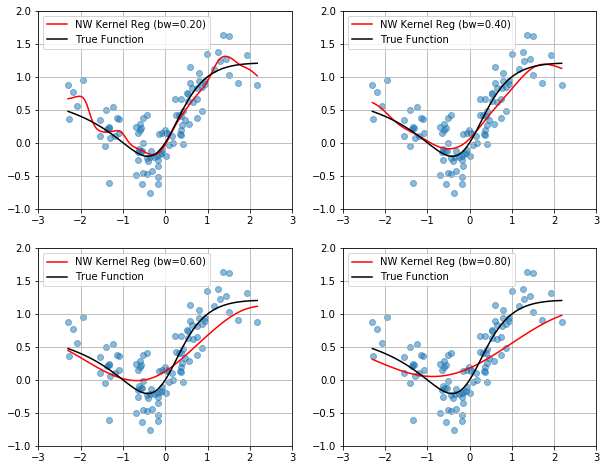

In [29]:
# Kernel regression with different bandwidth values
bw_silverman = (4/(3*len(X)))**0.2*np.std(X)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10, 8))
ax1.plot(x, kern_reg(x, X, Y, 0.5*bw_silverman, gauss_kern), color='r', label='NW Kernel Reg (bw={:.2f})'.format(0.5*bw_silverman))
ax1.scatter(X, Y, alpha=0.5)
ax1.plot(x, f(x), 'k', label='True Function')
ax1.legend(loc=0)
ax2.plot(x, kern_reg(x, X, Y, bw_silverman, gauss_kern), color='r', label='NW Kernel Reg (bw={:.2f})'.format(bw_silverman))
ax2.scatter(X, Y, alpha=0.5)
ax2.plot(x, f(x), 'k', label='True Function')
ax2.legend(loc=0)
ax3.plot(x, kern_reg(x, X, Y, 1.5*bw_silverman, gauss_kern), color='r', label='NW Kernel Reg (bw={:.2f})'.format(1.5*bw_silverman))
ax3.scatter(X, Y, alpha=0.5)
ax3.plot(x, f(x), 'k', label='True Function')
ax3.legend(loc=0)
ax4.plot(x, kern_reg(x, X, Y, 2*bw_silverman, gauss_kern), color='r', label='NW Kernel Reg (bw={:.2f})'.format(2*bw_silverman))
ax4.scatter(X, Y, alpha=0.5)
ax4.plot(x, f(x), 'k', label='True Function')
ax4.legend(loc=0)

In [30]:
# Define a new kernel function
def quartic_kern(x):
    """Quartic kernel function"""
    ub = np.ones_like(x)
    return np.where(np.abs(x)<=ub, ((1+x)**2) * ((1-x)**2), 0)

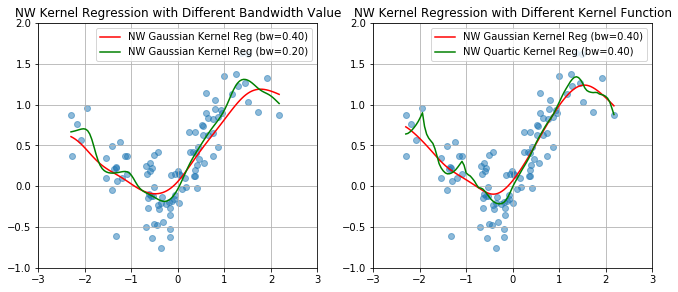

In [31]:
fig, axs = plt.subplots(1,2, figsize=(11, 4.5))
axs[0].plot(x, kern_reg(x, X, Y, bw_silverman, gauss_kern), color='r', label='NW Gaussian Kernel Reg (bw={:.2f})'.format(bw_silverman))
axs[0].plot(x, kern_reg(x, X, Y, 0.5*bw_silverman, gauss_kern), color='g', label='NW Gaussian Kernel Reg (bw={:.2f})'.format(0.5*bw_silverman))
axs[0].set_title('NW Kernel Regression with Different Bandwidth Value')
axs[1].plot(x, ll_reg(x, X, Y, bw_silverman, gauss_kern), color='r', label='NW Gaussian Kernel Reg (bw={:.2f})'.format(bw_silverman))
axs[1].plot(x, ll_reg(x, X, Y, bw_silverman, quartic_kern), color='g', label='NW Quartic Kernel Reg (bw={:.2f})'.format(bw_silverman))
axs[1].set_title('NW Kernel Regression with Different Kernel Function')
for ax in axs:
    ax.scatter(X, Y, alpha=0.5)
    ax.legend(loc=0)

<b>Comments on Questions 1.2 Results</b>
<ul>
<li> When we keep the kernel function unchanged and try different bandwidth values, we observe that when the bandwidth is the theretical optimal value, the result is the best. As the bandwidth value becomes higher, the fitting becomes worse. And when the bandwidth value is too small, the fitting result becomes unstable.</li>
<li> To compare the effect of bandwidth value and kernel function on regression. we have two groups. In the first group, we keep the kernel function unchanged and use half of the optimal bandwidth value. In the second group, we maintain the bandwidth value and change the kernel function. By comparing two groups, we find that changing bandwidth value has large impact but is also more stable than changing kernel function.
</ul>

# 2. American Option Pricing

In [32]:
def blackscholes_mc(S=100, vol=0.2, r=0, q=0, ts=np.linspace(0, 1, 13), npaths=10):
    """Generate Monte-Carlo paths in Black-Scholes model.

    Parameters
    ----------
    S: scalar
        The spot price of the underlying security.
    vol: scalar
        The implied Black-Scholes volatility.
    r: scalar
        The annualized risk-free interest rate, continuously compounded.
    q: scalar
        The annualized continuous dividend yield.
    ts: array_like
        The time steps of the simualtion
    npaths: int
        the number of paths to simulate

    Returns
    -------
    paths: ndarray
        The Monte-Carlo paths.
    """
    nsteps = len(ts) - 1
    ts = np.asfarray(ts)[:, np.newaxis]
    W = np.cumsum(np.vstack((np.zeros((1, npaths), dtype=np.float),
                             np.random.randn(nsteps, npaths) * np.sqrt(np.diff(ts, axis=0)))),
                  axis=0)
    paths = np.exp(-0.5*vol**2*ts + vol*W)*S*np.exp((r-q)*ts)
    return paths

In [33]:
# Parameters
S = 100
vol = 0.2
r = 0.1
q = 0.02
K = 100
T = 1

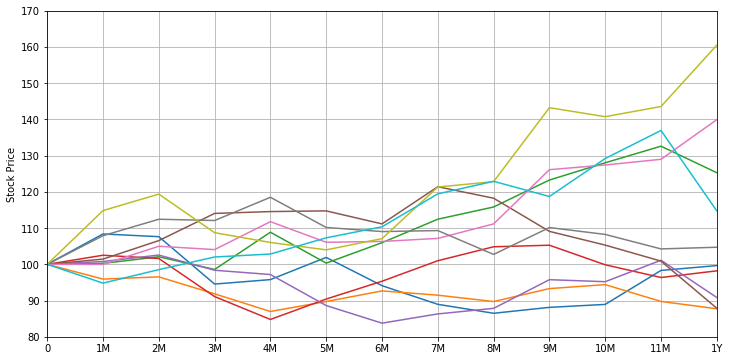

In [34]:
ts = np.linspace(0, 1, 13)
npaths = 10000
paths = blackscholes_mc(S, vol, r, q, ts=ts, npaths=npaths)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts, paths[:, :10])
ax.set_xticks(ts)
ax.set_xticklabels(['0', '1M', '2M', '3M', '4M', '5M', '6M', '7M', '8M', '9M', '10M', '11M', '1Y'])
ax.set_ylabel('Stock Price')
ax.grid(True)

### Price of European put option

In [35]:
np.mean(np.maximum(K-paths[-1], 0))*np.exp(-r*T)

4.2411401755392486

### Price of Bermudan put option with monthly exercises

#### Longstaff-Schwartz algorithm

We use polynomials as basis functions for demonstration purposes.

In [36]:
payoff = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    p = np.polyfit(paths[i], payoff, deg=2)
    contval = np.polyval(p, paths[i])
    exerval = np.maximum(K-paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]
np.mean(payoff*np.exp(-r*(ts[1]-ts[0])))

4.9064964833802005

#### Tsitsiklis-van Roy algorithm

The price from the TVR algorithm is generally too high because regression errors accumulate in the backward induction.

In [37]:
V = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    p = np.polyfit(paths[i], V*discount, deg=2)
    contval = np.polyval(p, paths[i])
    exerval = np.maximum(K-paths[i], 0)
    V = np.maximum(exerval, contval)
np.mean(V)*np.exp(-r*(ts[1]-ts[0]))

6.2067084128015804

## Questions

<b>Question 2.1</b>. Adapt the Longstaff-Schwartz and TVR code to use different regression methods:

<b>(a).</b> Weighted Laguerre polynomials $\tilde{L}_n$ up to degree 2 as basis functions. 
<br>
Note: since the weighted Laguerre polynomials have an exponential term, directly using them may result in numerical underflow. One way to avoid this to renormalize the stock price by the strike price, i.e. regress on $\tilde{L}_n(S/K)$.</li>

<b>(b).</b> Black-Scholes put prices.
<br>
Use the constant 1.0 and the Black-Scholes price of a European put option with volatility $\bar\sigma = 0.2$ and maturity $T-t$ as the two basis functions at time $t$. For your convenience, the Black-Scholes pricing formula is included in the cell below.

<b>(c).</b> Piecewise Linear regression.

Note: choose the number of knots appropriately in the regression.</li>

<b>(d).</b> Kernel regression with Gaussian kernel.

Note: Choose the bandwidth appropriately.</li>

In [38]:
import scipy.stats as sts
def blackscholes_price(K, T, S, vol, r=0, q=0, callput='call'):
    """Compute the call/put option price in the Black-Scholes model
    
    Parameters
    ----------
    K: scalar or array_like
        The strike of the option.
    T: scalar or array_like
        The maturity of the option, expressed in years (e.g. 0.25 for 3-month and 2 for 2 years)
    S: scalar or array_like
        The current price of the underlying asset.
    vol: scalar or array_like
        The implied Black-Scholes volatility.
    r: scalar or array_like
        The annualized risk-free interest rate, continuously compounded.
    q: scalar or array_like
        The annualized continuous dividend yield.
    callput: str
        Must be either 'call' or 'put'.

    Returns
    -------
    price: scalar or array_like
        The price of the option.

    Examples
    --------
    >>> blackscholes_price(95, 0.25, 100, 0.2, r=0.05, callput='put')
    1.5342604771222823
    """
    F = S*np.exp((r-q)*T)
    v = np.sqrt(vol**2*T)
    d1 = np.log(F/K)/v + 0.5*v
    d2 = d1 - v
    try:
        opttype = {'call':1, 'put':-1}[callput.lower()]
    except:
        raise ValueError('The value of callput must be either "call" or "put".')
    price = opttype*(F*sts.norm.cdf(opttype*d1)-K*sts.norm.cdf(opttype*d2))*np.exp(-r*T)
    return price

In [39]:
#Weighted Laguerre polynomials up to degree 2 as basis functions.
payoff = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    A = np.vstack((L(paths[i]/K, 0), L(paths[i]/K, 1), L(paths[i]/K, 2))).T
    p = np.linalg.lstsq(A, payoff)[0]
    contval = L(paths[i]/K, 0)*p[0]+L(paths[i]/K, 1)*p[1]+L(paths[i]/K, 2)*p[2]  
    exerval = np.maximum(K-paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]

V = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    A = np.vstack((L(paths[i]/K, 0), L(paths[i]/K, 1), L(paths[i]/K, 2))).T
    p = np.linalg.lstsq(A, V*discount)[0]
    contval = L(paths[i]/K, 0)*p[0]+L(paths[i]/K, 1)*p[1]+L(paths[i]/K, 2)*p[2]
    exerval = np.maximum(K-paths[i], 0)
    V = np.maximum(exerval, contval)

print ("Price of Bermudan put option via Longstaff-Schwartz algorithm: %f" % np.mean(payoff*np.exp(-r*(ts[1]-ts[0]))))
print ("Price of Bermudan put option via Tsitsiklis-van Roy algorithm: %f" % np.mean(V*np.exp(-r*(ts[1]-ts[0]))))

Price of Bermudan put option via Longstaff-Schwartz algorithm: 4.926441
Price of Bermudan put option via Tsitsiklis-van Roy algorithm: 5.880193


In [40]:
#Use the constant 1.0 and the Black-Scholes price of a European put option as the two basis functions
payoff = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    bsm_put = blackscholes_price(K, T-ts[i], paths[i], vol, r, q, callput='put')
    A = np.vstack((np.ones_like(paths[i]),bsm_put)).T
    p = np.linalg.lstsq(A, payoff)[0]
    contval = p[0]+bsm_put*p[1]  
    exerval = np.maximum(K-paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]

V = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    bsm_put = blackscholes_price(K, T-ts[i], paths[i], vol, r, q, callput='put')
    A = np.vstack((np.ones_like(paths[i]),bsm_put)).T
    p = np.linalg.lstsq(A, V*discount)[0]
    contval = p[0]+bsm_put*p[1] 
    exerval = np.maximum(K-paths[i], 0)
    V = np.maximum(exerval, contval)

print ("Price of Bermudan put option via Longstaff-Schwartz algorithm: %f" % np.mean(payoff*np.exp(-r*(ts[1]-ts[0]))))
print ("Price of Bermudan put option via Tsitsiklis-van Roy algorithm: %f" % np.mean(V*np.exp(-r*(ts[1]-ts[0]))))

Price of Bermudan put option via Longstaff-Schwartz algorithm: 5.081337
Price of Bermudan put option via Tsitsiklis-van Roy algorithm: 5.179280


In [41]:
#Piecewise Linear regression with 4 knots
payoff = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    xknots = np.linspace(np.percentile(paths[i], 5), np.percentile(paths[i], 95), 4)
    fpl = piecewiselinear_reg(paths[i], payoff, xknots, 'linear')
    contval = fpl(paths[i])  
    exerval = np.maximum(K-paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]

V = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    xknots = np.linspace(np.percentile(paths[i], 5), np.percentile(paths[i], 95), 4)
    fpl = piecewiselinear_reg(paths[i], V*discount, xknots, 'linear')
    contval = fpl(paths[i])
    exerval = np.maximum(K-paths[i], 0)
    V = np.maximum(exerval, contval)

print ("Price of Bermudan put option via Longstaff-Schwartz algorithm: %f" % np.mean(payoff*np.exp(-r*(ts[1]-ts[0]))))
print ("Price of Bermudan put option via Tsitsiklis-van Roy algorithm: %f" % np.mean(V*np.exp(-r*(ts[1]-ts[0]))))

Price of Bermudan put option via Longstaff-Schwartz algorithm: 4.710071
Price of Bermudan put option via Tsitsiklis-van Roy algorithm: 6.831260


In [43]:
#Kernel regression with Gaussian kernel
payoff = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    bw_silverman = (4/(3*len(paths[i])))**0.2*np.std(paths[i])
    contval = kern_reg(paths[i], paths[i], payoff, bw_silverman, gauss_kern)
    exerval = np.maximum(K-paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]

V = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    bw_silverman = (4/(3*len(paths[i])))**0.2*np.std(paths[i])
    contval = kern_reg(paths[i], paths[i], V*discount, bw_silverman, gauss_kern)
    exerval = np.maximum(K-paths[i], 0)
    V = np.maximum(exerval, contval)

print ("Price of Bermudan put option via Longstaff-Schwartz algorithm: %f" % np.mean(payoff*np.exp(-r*(ts[1]-ts[0]))))
print ("Price of Bermudan put option via Tsitsiklis-van Roy algorithm: %f" % np.mean(V*np.exp(-r*(ts[1]-ts[0]))))

Price of Bermudan put option via Longstaff-Schwartz algorithm: 5.103662
Price of Bermudan put option via Tsitsiklis-van Roy algorithm: 5.427241


<b>Comments on Questions 2.1 Results</b>
<ul>
<li> When we use weighted Laguerre polynomials up to degree 2 as basis functions, the Bermudan put option values via Longstaff-Schwartz or Tsitsiklis-van Roy algorithm are similar with those using quadratic polynomial as basis functions.</li>
<li> When we use Black-Scholes put prices as basis functions, the cumulative bias of Tsitsiklis-van Roy algorithm is largely reduced such that the option values using Longstaff-Schwartz and Tsitsiklis-van Roy algorithms are very close.</li>
<li> When we use piecewise linear regression, the difference between option values using two algorithms becomes very large.</li>
<li> When we use kernel function as basis function, the difference between two option values is reduced.
</ul>

<b>Question 2.2</b> In pricing the Bermudan put option with monthly exercises above by Longstaff-Schwartz algorithm, we have considered 

<b>(a).</b> quadratic polynomial basis functions;

<b>(b).</b> basis functions given in Question 2.1(b)

For each case, identify and plot the exercise and continuation regions at time $t=0.5$. Comment on the result.

Text(0.5,1,'BSM Put Option Price Basis Function')

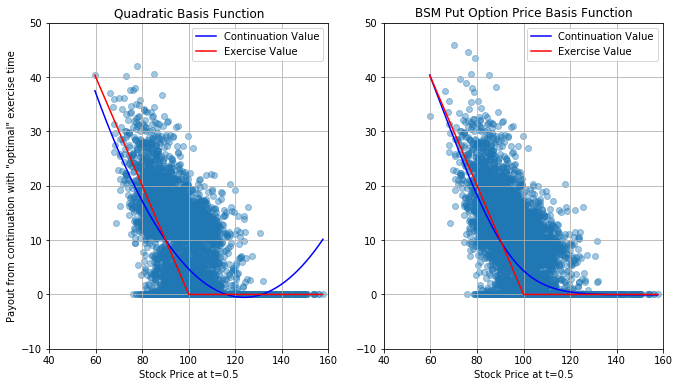

In [44]:
#Black-Scholes put price as basis function
payoff1 = np.maximum(K-paths[-1], 0)
payoff2 = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 7, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff1 = payoff1*discount
    payoff2 = payoff2*discount
    p1 = np.polyfit(paths[i], payoff1, deg=2)
    bsm_put = blackscholes_price(K, T-ts[i], paths[i], vol, r, q, callput='put')
    A = np.vstack((np.ones_like(paths[i]),bsm_put)).T
    p2 = np.linalg.lstsq(A, payoff2)[0]
    contval1 = np.polyval(p1,paths[i])
    contval2 = p2[0]+bsm_put*p2[1]  
    exerval = np.maximum(K-paths[i], 0)
    # identify the paths where we should exercise
    ind1 = exerval > contval1
    payoff1[ind1] = exerval[ind1]
    ind2 = exerval > contval2
    payoff2[ind2] = exerval[ind2]

discount = np.exp(-r*(ts[6]-ts[5]))
St = np.linspace(paths[5].min(),paths[5].max(),len(paths[5]))
p1 = np.polyfit(paths[5], payoff1*discount, deg=2)
bsm_put = blackscholes_price(K, T-ts[5], paths[5], vol, r, q, callput='put')
A = np.vstack((np.ones_like(paths[5]),bsm_put)).T
p2 = np.linalg.lstsq(A, payoff2*discount)[0]
contval1 = np.polyval(p1,St)
contval2 = p2[0]+blackscholes_price(K, T-ts[5], St, vol, r, q, callput='put')*p2[1] 

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11,6)) 
ax1.scatter(paths[5],payoff1*discount,alpha=0.4)
ax1.plot(St,contval1,color='b',label='Continuation Value')
ax1.plot(St,np.maximum(K-St,0),color='r',label='Exercise Value')
ax1.legend(loc=0)
ax1.set_xlabel('Stock Price at t=0.5')
ax1.set_ylabel('Payout from continuation with "optimal" exercise time')
ax1.set_title('Quadratic Basis Function')
ax2.scatter(paths[5],payoff2*discount,alpha=0.4)
ax2.plot(St,contval2,color='b',label='Continuation Value')
ax2.plot(St,np.maximum(K-St,0),color='r',label='Exercise Value')
ax2.legend(loc=0)
ax2.set_xlabel('Stock Price at t=0.5')
ax2.set_title('BSM Put Option Price Basis Function')

<b>Comments on Questions 2.2 Results</b>
<ul>
<li>When the continuation value is below the immediate exercise value, we should exercise the option. Otherwise, we should continue. In both graphs, we observe that we should exercise the option when the option is deep in-the-money. This is reasonable, because stock price is very likely to bounce in the future.</li>
<li>However, two regression methods differ in the tail when option is deep out-of-the-money. When we use quadratic polynomial, we observe that the continuation value is much higher than the exercise value at tail distribution, partly because of the quadratic property, which is not likely to happen in reality. However, when we use BSM formula as basis function, we have the continuation value overlapping with the exercise value, which is more reasonable because when option is deep out-of-the-money, both exercising it and continuing bring little value.
</ul>

<b>Question 2.3</b>. Both TVR and Longstaff-Schwartz algorithms provide an estimate for the expected payoff from continuation at each exercise date from the cross-sectional information in the simulation using regression. By comparing this estimate with the immediate exercise value, the holder of the option can determine whether to exercise the option or continue. 

Perform an independent Monte Carlo simulation using this estimate of continuation value from both algorithms as an exercise policy, and estimate the price of the American put. Explain why this estimate is a lower bound. The basis functions for regression can be chosen to be the quadratic polynomial as in the sample code.

Show your code and result with at least 100000 simulations.

In [45]:
# First obtain the optimal strategy estimation using Monte Carlo simulation via two algorithms respectively
payoff = np.maximum(K-paths[-1], 0)
V = np.copy(payoff)
P1 = np.zeros((len(ts)-2,3))
P2 = np.copy(P1)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    P1[i-1] = np.polyfit(paths[i], payoff, deg=2)
    P2[i-1] = np.polyfit(paths[i], V*discount, deg=2)
    contval1 = np.polyval(P1[i-1], paths[i])
    contval2 = np.polyval(P2[i-1], paths[i])
    exerval = np.maximum(K-paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval1
    payoff[ind] = exerval[ind]
    V = np.maximum(exerval, contval2)

# Then use the estimations above for the second independent Monte Carlo simulation with 10000 paths
npaths = 100000
def second_mcs(S, K, vol, r, q, ts, npaths, P):
    value = np.zeros(npaths)
    nsteps = len(ts) - 1
    paths = np.zeros((nsteps+1,npaths))
    paths[0] = S
    rn = np.random.standard_normal((nsteps,npaths))
    for j in range(npaths):
        for i in range(1,nsteps):
            paths[i,j]=paths[i-1,j]*np.exp((r-q-0.5*vol**2)*(ts[i]-ts[i-1])+vol*np.sqrt(ts[i]-ts[i-1])*rn[i-1,j])
            exval = np.maximum(K-paths[i,j], 0)
            conval = np.polyval(P[i-1], paths[i,j])
            value[j] = exval*np.exp(-r*ts[i])
            # identify whether exercise or continue the option
            if (exval > conval):
                break
    return np.mean(value)

amer_put1 = second_mcs(S, K, vol, r, q, ts, npaths, P1)
amer_put2 = second_mcs(S, K, vol, r, q, ts, npaths, P2)
print ('Price of American Put Option using independet simulation with Longstaff-Schwartz estimation: %f' % amer_put1)
print ('Price of American Put Option using independet simulation with Tsitsiklis-van Roy estimation: %f' % amer_put2)

Price of American Put Option using independet simulation with Longstaff-Schwartz estimation: 4.822680
Price of American Put Option using independet simulation with Tsitsiklis-van Roy estimation: 4.796540


<b>Comments on Questions 2.3 Results</b>
<ul>
<li> We can observe that if we use independent simulation to calculate American put option value, then the difference between Longstaff-Schwartz algorithm and Tsitsiklis-van Roy algorithm becomes very small.</li>
<li> This estimate is a lower bound because this estimate is a optimal stopping time value, which represents the option holder's perspective. 
</ul>

<b>Question 2.4</b>. Experiment different exercise frequencies (quarterly, monthly and daily) and various interest rates level. Comment on the dependence of Bermudan put price on the exercise frequencies and interest rates.

In [46]:
# Estimate optimal strategy via Longstaff-Schwartz algorithm
def LS_est(K, paths, r, ts):
    payoff = np.maximum(K-paths[-1], 0)
    P = np.zeros((len(ts)-2,3))
    for i in range(len(ts)-2, 0, -1):
        discount = np.exp(-r*(ts[i+1]-ts[i]))
        payoff = payoff*discount
        P[i-1] = np.polyfit(paths[i], payoff, deg=2)
        contval = np.polyval(P[i-1], paths[i])
        exerval = np.maximum(K-paths[i], 0)
        # identify the paths where we should exercise
        ind = exerval > contval1
        payoff[ind] = exerval[ind]
    return P

# parameters
npaths1 = 10000 # fist round simulation path number
npaths2 = 100000 # second round simulation path number
ts1 = np.linspace(0,1,5) # quarterly
ts2 = np.linspace(0,1,13) # monthly
ts3 = np.linspace(0,1,366) # daily
r_list = np.linspace(0,0.1,6) # various interest rate level

# Compute Bermudan put option value with zero interest rate for different exercise frequency
paths1 = blackscholes_mc(S, vol, r, q, ts1, npaths1)
paths2 = blackscholes_mc(S, vol, r, q, ts2, npaths1)
paths3 = blackscholes_mc(S, vol, r, q, ts3, npaths1)
P1 = LS_est(K, paths1, r, ts1)
P2 = LS_est(K, paths2, r, ts2)
P3 = LS_est(K, paths3, r, ts3)
ber_put1 = second_mcs(S, K, vol, r, q, ts1, npaths2, P1)
ber_put2 = second_mcs(S, K, vol, r, q, ts2, npaths2, P2)
ber_put3 = second_mcs(S, K, vol, r, q, ts3, npaths2, P3)

print ('Price of Bermudan put option with quarterly exercise frequency and zero interest rate is: %f' % ber_put1)
print ('Price of Bermudan put option with monthly exercise frequency and zero interest rate is: %f' % ber_put2)
print ('Price of Bermudan put option with daily exercise frequency and zero interest rate is: %f' % ber_put3)
print ('---')

for i in range(6):
    paths = blackscholes_mc(S, vol, r_list[i], q, ts2, npaths1)
    P = LS_est(K, paths, r_list[i], ts2)
    ber_put = second_mcs(S, K, vol, r_list[i], q, ts2, npaths2, P)
    print ('Price of Bermudan put option with monthly exercise frequency and %3f interest rate is: %f' % (r_list[i], ber_put))

Price of Bermudan put option with quarterly exercise frequency and zero interest rate is: 4.526354
Price of Bermudan put option with monthly exercise frequency and zero interest rate is: 4.829554
Price of Bermudan put option with daily exercise frequency and zero interest rate is: 4.455420
---
Price of Bermudan put option with monthly exercise frequency and 0.000000 interest rate is: 8.061841
Price of Bermudan put option with monthly exercise frequency and 0.020000 interest rate is: 7.203992
Price of Bermudan put option with monthly exercise frequency and 0.040000 interest rate is: 6.503203
Price of Bermudan put option with monthly exercise frequency and 0.060000 interest rate is: 5.853077
Price of Bermudan put option with monthly exercise frequency and 0.080000 interest rate is: 5.369016
Price of Bermudan put option with monthly exercise frequency and 0.100000 interest rate is: 4.823784


<b>Comments on Questions 2.4 Results</b>
<ul>
<li> The value of Bermudan put option peaks at monthly exercise frequency.</li>
<li> The value of Bermudan put option decreases as the interest rate rises.
</ul>

<b>Question 2.5</b>. Use the Longstaff-Schwartz algorithm to price an Bermudan-Asian call option. The underlying security price is assumed to follow the geometric Brownian motion

$$\frac{dS_t}{S_t}=(r-q)dt+\sigma dW_t$$

with $S_0=100$, $r=0$, $q=0$ and $\sigma=0.2$. The option has a strike of $K=100$ and a final expiration date of $T=1$ and can be exercised every month before the final maturity, i.e.
$$t_1=\frac{1}{12},\, t_2=\frac{2}{12},\, \ldots,\, t_{12}=1$$

The cashflow from exercising the option at time $t_n$, $n=1,\ldots,12$, is $\max\left(0, A_{t_n}-K\right)$ with $A_{t_n}=\frac{1}{n}\sum_{i=1}^nS_{t_i}$.

As the basis functions in the regression at time $t_n$, use the constant 1.0 and the Black-Scholes value of a European call option with strike $K$, maturity $T-t_n$, and volatility $\bar\sigma = 0.1$, written on
$$
Z_{t_n}\equiv \frac{nA_{t_n}+(12-n)S_{t_n}}{12}
$$

Show your code and result with at least 100000 simulations. Try different values of $\bar\sigma$. Explain the use of $Z_{t_n}$ instead of simply $A_{t_n}$ or $S_{t_n}$.

Text(0.5,1,'Value of Bermudan-Asian Call Option')

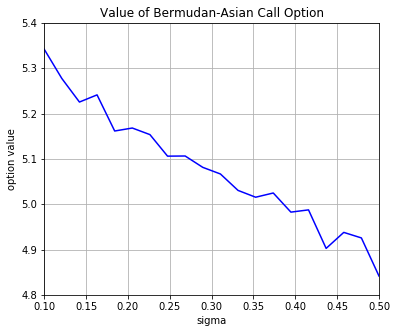

In [47]:
npaths = 100000
S = 100
K = 100
ts = np.linspace(0,1,13)
r = 0
q = 0
vol = 0.2
sigmas = np.linspace(0.1,0.5,20)
def asia_call(S, K, vol, r, q, ts, npaths, sigma):
    paths = blackscholes_mc(S, vol, r, q, ts=ts, npaths=npaths)
    x = np.linspace(0,12,13)
    x[0] = 1
    W = np.cumsum(paths, axis=0)
    # Average stock price
    W = (W - W[0]) / x[:,np.newaxis]
    payoff = np.maximum(W[-1]-K,0)

    for i in range(len(ts)-2, 0, -1):
        discount = np.exp(-r*(ts[i+1]-ts[i]))
        payoff = payoff*discount
        Z = (i*W[i]+(12-i)*paths[i])/12
        bsm_call = blackscholes_price(K, T-ts[i], Z, sigma, r, q, callput='call')
        A = np.vstack((np.ones_like(paths[i]),bsm_call)).T
        p = np.linalg.lstsq(A, payoff)[0]
        contval = p[0]+bsm_call*p[1]  
        exerval = np.maximum(W[i]-K, 0)
        # identify the paths where we should exercise
        ind = exerval > contval
        payoff[ind] = exerval[ind]

    asian_call = np.mean(payoff) * np.exp(-r*(ts[1]-ts[0]))
    return asian_call

call_value = np.zeros_like(sigmas)
for i in range(len(sigmas)):
    call_value[i] = asia_call(S, K, vol, r, q, ts, npaths, sigmas[i]) 
    
fig, ax = plt.subplots()
ax.plot(sigmas, call_value, color='b')
ax.set_xlabel('sigma')
ax.set_ylabel('option value')
ax.set_title('Value of Bermudan-Asian Call Option')

<b>Comments on Questions 2.5 Results</b>
<ul>
<li> The value of the Bermudan-Asian call option is inversely related with the value of sigma.</li>
<li> This algorithm uses $Z_{t_n}$ instead of simply $A_{t_n}$ or $S_{t_n}$ because the option is written on the stock, but the exericise value is path dependent, so it makes a compromise between stock price and exercise value.
</ul>